# Import Necessary Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Patch
from scipy.optimize import direct

# Cost Function

In [2]:
def cost(waypoint_coords: np.ndarray, # Flat representation of waypoints, i.e. (1, 6) and (2, 4) represented as [1, 6, 2, 4]
        start: np.ndarray, # Start point of the path
        end: np.ndarray, # End point of the path
        threats: list, # List of tuples, each containing a threat center and radius. Threat center is a np.ndarray like start and end
        lmin: int, # Minimum leg length
        phi_max: np.float64, # Maximum turn angle in radians
        mu: int, # Penalty for leg length
        nu: int, # Penalty for turn angle
        rho: int, # Penalty for threat distance
        sigma_max=4.0) -> np.float64: # Maximum step size for sampling

    PENALTY_EXPONENT = 3 # Exponent for the in threat distance penalty

    # Get a list of all the waypoints in order.
    # reshape(-1, 2) converts the flat representation into a 2D array of shape (n, 2)
    # vstack puts the start and end points into the correct positions.
    waypoints = np.vstack([start, waypoint_coords.reshape(-1, 2), end]) 

    # Calculate each leg length
    legs = np.diff(waypoints, axis=0) # Get the vector representation of each leg
    leg_lengths = np.linalg.norm(legs, axis=1) # Compute the magnitude of each leg vector

    # Calculate turn angles
    turn_angles = []
    for j in range(1, len(legs)): # Start from the second leg because the first leg has no previous leg to compare to 
        norm_prev = np.linalg.norm(legs[j-1]) # Magnitude of the previous leg (magnitude = norm = length for vectors)
        norm_curr = np.linalg.norm(legs[j])

        if norm_prev < 1e-6 or norm_curr < 1e-6:
            turn_angles.append(0.0)
            continue
        dot_product = np.dot(legs[j-1], legs[j])
        
        cos_phi = dot_product / (norm_prev * norm_curr) # Normalize the dot product to get the cosine of the angle, Definition of dot product: u⋅v = |u||v|cosθ
        angle = np.arccos(np.clip(cos_phi, -1, 1)) # Use arccos to get the angle from the cosine value. np.clip prevents out-of-bounds errors.
        turn_angles.append(angle)

    #turn_angles = [ np.arccos(np.clip(np.dot(legs[j-1], legs[j]) / (np.linalg.norm(legs[j-1]) * np.linalg.norm(legs[j])), -1, 1)) for j in range(1, len(legs)) ]
    
    # Calculate total cost
    total_cost = np.sum(leg_lengths) # Total path length
    total_cost += np.sum(mu * np.maximum(lmin - leg_lengths, 0) ** 2) # Leg length penalties
    
    # PENALTY WITH DEGREES, this was so important to figure out.
    total_cost += np.sum(nu * np.maximum(np.degrees(turn_angles) - np.degrees(phi_max), 0) ** 2) # Turn angle penalties
    
    # PENALTY WITH RADIANS
    #total_cost += np.sum(nu * np.maximum(turn_angles - phi_max, 0) ** 2) # Turn angle penalties

    # Threat penalties
    for threat_centre, threat_radius in threats:
        # Calculate and sum the in-threat distance of each leg
        l_ji = sum(in_threat_distance(waypoints[j], waypoints[j+1], threat_centre, threat_radius, sigma_max) for j in range(len(legs)))
        total_cost += rho * (l_ji ** PENALTY_EXPONENT)

    return total_cost

# Helper Functions

In [3]:
def T_i(point: np.ndarray, center: np.ndarray, radius: int) -> float:
    """Calculate the distance from a point to the threat zone, negative value indicates inside the zone"""
    return np.linalg.norm(point - center) - radius
    
def in_threat_distance(start: np.ndarray, end: np.ndarray, center: np.ndarray, radius: int, sigma_max: int) -> float:  
    """Calculate the in-threat distance of a leg"""

    l_j = np.linalg.norm(end - start) # Magnitude of the leg vector
    if l_j == 0: # Check if leg-length is zero
        return 0 
    l_ji = 0.0  # initialize in-threat distance accumulator
    K_max = int(np.ceil(l_j / sigma_max))  # The total number of samples along the leg
    delta_lambda = 1 / K_max # Step size

    # If the starting point is inside the threat zone, set lambda_b to 0
    if T_i(start, center, radius) <= 0:
        lambda_b = 0

    # Loop through each step along the leg
    for k in range(1, K_max+1):
        lambda_k = k * delta_lambda # Current normalized distance along the leg. k = num steps and delta_lambda = normalized step size
        u_k = start + lambda_k * (end - start) # Current point along the leg. lambda_k * (end - start) = Actual point on the leg (not normalized)
        T_k = T_i(u_k, center, radius) # Calculate the distance from the current point to the threat zone

        u_k_prev = start + (lambda_k - delta_lambda) * (end - start) # Previous point along the leg
        T_k_prev = T_i(u_k_prev, center, radius) # Calculate the distance from the previous point to the threat zone

        # Entering threat zone, meaning current point is inside and the previous was outside
        if T_k <= 0 and T_k_prev > 0:
            kappa = T_k / (T_k - T_k_prev) # Ratio of the distance to the threat zone at the current point to the distance at the previous point
            lambda_b = (k - kappa) * delta_lambda # Normalized distance at which the leg enters the threat zone
        
        # Exiting threat zone, meaning the current point is outside and the previous was inside
        if T_k > 0 and T_k_prev <= 0:
            kappa = T_k / (T_k - T_k_prev) # Same as above, but for exiting the zone
            lambda_e = (k - kappa) * delta_lambda # Normalized distance at which the leg exits the threat zone
            l_ji += (lambda_e - lambda_b) * l_j # Accumulate the in-threat distance since we have now exited the zone
            lambda_b = None # Reset lambda_b for the next leg
    
    # If ending inside threat zone
    if T_i(end, center, radius) <= 0 and lambda_b is not None:
        l_ji += (1.0 - lambda_b) * l_j # Accumulate the in-threat distance 
    return l_ji

def calculate_path_length(waypoints: np.ndarray) -> np.float64:
    """Calculate the length of a path defined by waypoints"""
    legs = np.diff(waypoints, axis=0)
    return np.sum(np.linalg.norm(legs, axis=1))

def calculate_max_turn_angle(waypoints: np.ndarray) -> float:
    """Calculate the maximum turn angle for a given path"""
    legs = np.diff(waypoints, axis=0)
    turn_angles = []
    for j in range(1, len(legs)):
        norm_prev = np.linalg.norm(legs[j - 1])
        norm_curr = np.linalg.norm(legs[j])
        if norm_prev < 1e-6 or norm_curr < 1e-6:
            continue  # Skip turn angle calculation for zero-length legs
        cos_phi = np.dot(legs[j - 1], legs[j]) / (norm_prev * norm_curr)
        angle = np.degrees(np.arccos(np.clip(cos_phi, -1, 1)))
        turn_angles.append(angle)
    return max(turn_angles) if turn_angles else 0

def print_report(result, origin, destination, threats):
    out_waypoints = result.x.reshape(-1, 2)
    out_cost = result.fun

    # Calculate the path length
    outbound_path = np.vstack([origin, out_waypoints, destination])
    outbound_length = calculate_path_length(outbound_path)

    # Calculate maximum turn angle
    max_turn_angle = calculate_max_turn_angle(outbound_path)

    # Calculate total threat violation distance
    total_threat_violation = sum(
        in_threat_distance(outbound_path[j], outbound_path[j+1], center, radius, sigma_max=4.0)
        for j in range(len(outbound_path) - 1)
        for center, radius in threats
    )

    print(f"Path length: {outbound_length:.2f} km")
    print(f"Cost: {out_cost:.2f}")
    print(f"Maximum turn angle: {max_turn_angle:.2f} degrees")
    print(f"Total threat violation distance: {total_threat_violation:.2f} km")
    print(f"Number of function calls: {result.nfev}") 

    print(f"\nWaypoints:")
    for i in out_waypoints:
        print(f"  ({i[0]:.2f}, {i[1]:.2f})")
    print()

def create_bounds(lb, ub):
    """Takes in a list of waypoints and tolerances, returns bounding boxes for matplotlib
    
    returns 3 items in a list per waypoint:
    1. Tuple containing xmin and ymin
    2. width
    3. height"""
    lb = np.array(lb)
    ub = np.array(ub)
    boxes = []
    lb = lb.reshape(-1, 2)
    ub = ub.reshape(-1, 2)
    for i in range(len(lb)):
        boxes.append([(lb[i][0], lb[i][1]), ub[i][0]-lb[i][0], ub[i][1]-lb[i][1]])
    return boxes

def plot_path(result, start, end, threats, title="Optimized Path"):
    waypoints = result.x.reshape(-1, 2)
    full_path = np.vstack((start, waypoints, end))

    plt.figure(figsize=(10, 8))
    plt.plot(full_path[:, 0], full_path[:, 1], 'b-o', label='Path')
    plt.scatter(start[0], start[1], c='green', label='Start', s=100, zorder=5)
    plt.scatter(end[0], end[1], c='red', label='End', s=100, zorder=5)

    for center, radius in threats:
        circle = plt.Circle(center, radius, color='r', alpha=0.2)
        plt.gca().add_patch(circle)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    plt.show()

# Approach 1

The volume of the hyperrectangle containing the lowest function value found is below vol_tol=1e-16
Path length: 155.01 km
Cost: 155.01
Maximum turn angle: 33.58 degrees
Total threat violation distance: 0.00 km
Number of function calls: 9753

Waypoints:
  (67.44, 75.38)
  (77.74, 82.70)
  (129.66, 104.56)



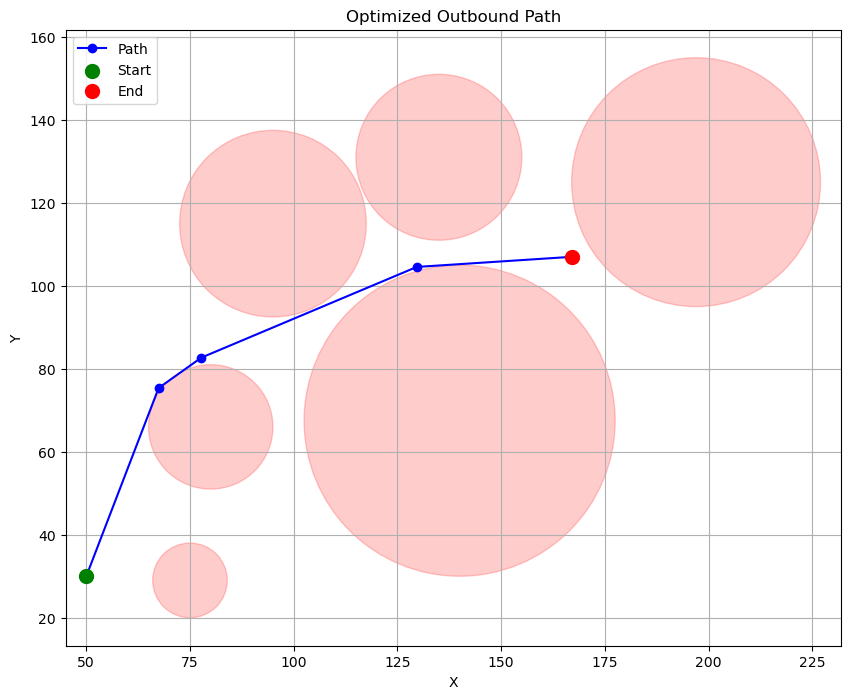

In [4]:
threats = [ 
    (np.array([75,  29]),    9),    
    (np.array([80,  66]),    15),   
    (np.array([95,  115]),   22.5), 
    (np.array([135, 131]),   20),   
    (np.array([140, 67.5]),  37.5), 
    (np.array([197, 125]),   30)    
]

origin = np.array([50, 30])
destination = np.array([167, 107])

# Final outbound leg optimization
lb_outbound = [68 - 5, 77 - 5, 97 - 30, 91 - 14, 128 - 5, 104 - 5]
ub_outbound = [68 + 5, 77 + 5, 97 + 30, 91 + 14, 128 + 5, 104 + 5]

phi_max_outbound = np.radians(42.5)
lmin_outbound = 10
mu_outbound = 1
nu_outbound = 1
rho_outbound = 1

result_outbound = direct(
    lambda waypoint_coords: cost(waypoint_coords, origin, destination, threats,
                                 lmin=lmin_outbound, phi_max=phi_max_outbound,
                                 mu=mu_outbound, nu=nu_outbound, rho=rho_outbound),
    bounds=list(zip(lb_outbound, ub_outbound)),
    maxiter=128,
    maxfun=16000,
    locally_biased=False
)

print(result_outbound.message)
print_report(result_outbound, origin, destination, threats)
plot_path(result_outbound, origin, destination, threats, title="Optimized Outbound Path")

Number of iterations is larger than maxiter=128
Path length: 292.39 km
Cost: 6694.75
Maximum turn angle: 42.82 degrees
Total threat violation distance: 4.07 km
Number of function calls: 27299

Waypoints:
  (167.10, 106.90)
  (195.35, 86.22)
  (202.83, 52.04)
  (184.39, 16.00)
  (131.38, -3.37)



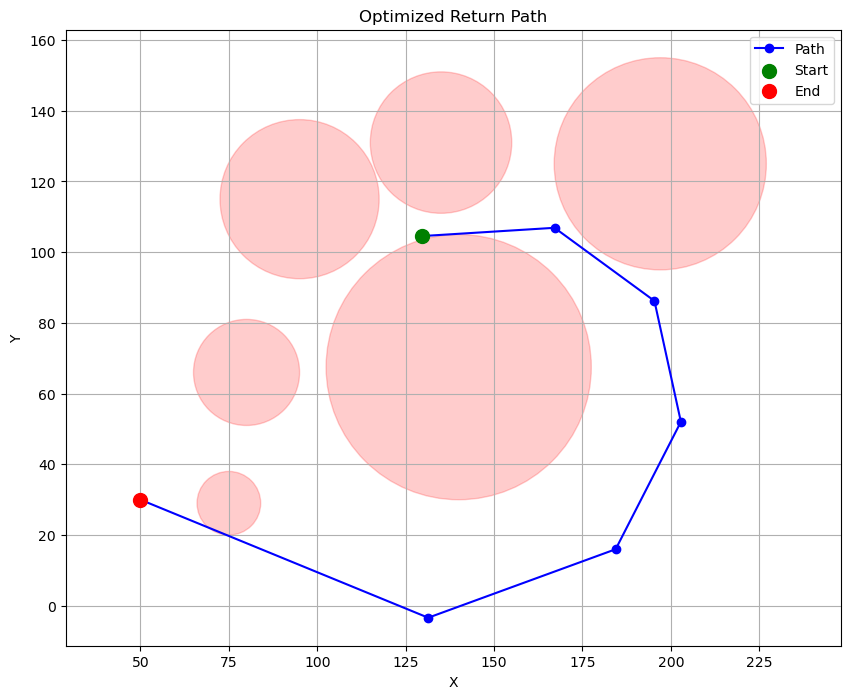

In [5]:
# Save final waypoint for return path
last_waypoint = result_outbound.x.reshape(-1, 2)[-1]

# Final return leg optimization
lb_return = [
    167 - 0.1, 107 - 0.1, 
    106 - 50, 64 - 75,
    107 - 50, 65 - 75,
    108 - 50, 66 - 75,
    109 - 50, 67 - 75]

ub_return = [
    167 + 0.1, 107 + 0.1,
    106 + 125, 64 + 75,
    107 + 125, 65 + 75,
    108 + 125, 66 + 75,
    109 + 125, 67 + 75]

phi_max_return = np.radians(30)
lmin_return = 10
mu_return = 1
nu_return = 10
rho_return = 1

result_return = direct(
    lambda waypoint_coords: cost(waypoint_coords, last_waypoint, origin, threats,
                                 lmin=lmin_return, phi_max=phi_max_return,
                                 mu=mu_return, nu=nu_return, rho=rho_return),
    bounds=list(zip(lb_return, ub_return)),
    maxiter=128,
    maxfun=60000,
    vol_tol=0,
    locally_biased=False
)

print(result_return.message)
print_report(result_return, last_waypoint, origin, threats)
plot_path(result_return, last_waypoint, origin, threats, title="Optimized Return Path")

# Approach 2

Refinement Result: Number of iterations is larger than maxiter=128
Path length: 401.87 km
Cost: 401.87
Maximum turn angle: 42.50 degrees
Total threat violation distance: 0.00 km
Number of function calls: 32443

Waypoints:
  (67.44, 75.38)
  (75.52, 81.59)
  (130.77, 104.56)
  (167.01, 106.90)
  (195.35, 84.29)
  (201.74, 54.18)
  (184.15, 23.04)
  (118.53, 0.33)



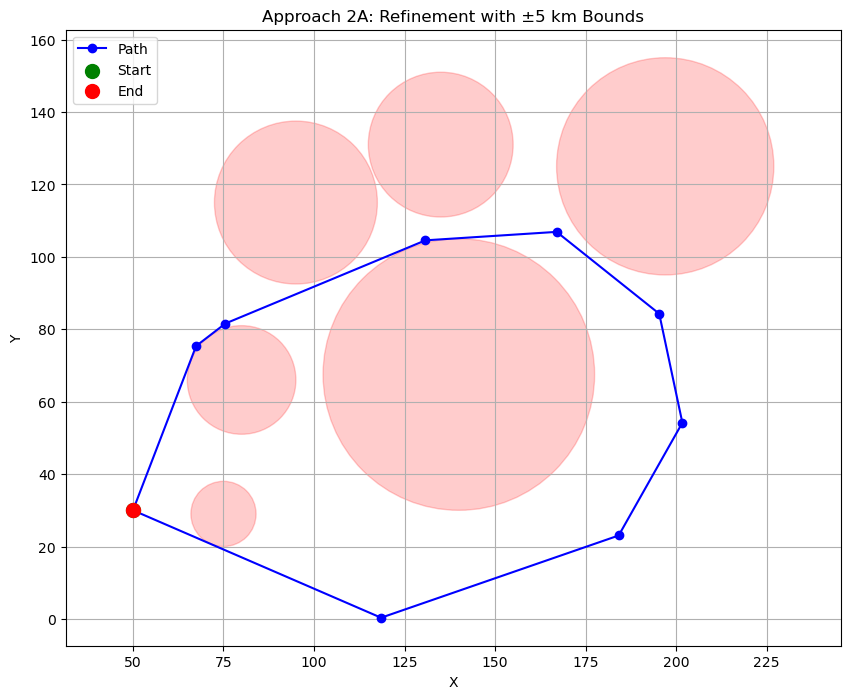

In [6]:
# Refinement Approach

# Bounds: ±5 km margin around waypoints from Approach 1
bounds_refinement = [
    (67.44 - 5, 67.44 + 5),   (75.38 - 5, 75.38 + 5),     # w1
    (77.74 - 5, 77.74 + 5),   (82.70 - 5, 82.70 + 5),     # w2
    (129.66 - 5, 129.66 + 5), (104.56 - 5, 104.56 + 5),   # w3
    (167.01 - 0.001, 167.01 + 0.001), (106.90 - 0.001, 106.90 + 0.001),  # w4 (fixed midpoint)
    (195.35 - 5, 195.35 + 5), (85.40 - 5, 85.40 + 5),     # w5
    (202.11 - 5, 202.11 + 5), (53.07 - 5, 53.07 + 5),     # w6
    (184.15 - 5, 184.15 + 5), (21.56 - 5, 21.56 + 5),     # w7
    (122.97 - 5, 122.97 + 5), (0.33 - 5, 0.33 + 5)        # w8
]

result_refinement = direct(
    lambda coords: cost(coords, origin, origin, threats,
                        lmin=10, phi_max=np.radians(42.5),
                        mu=1, nu=10, rho=1),
    bounds=bounds_refinement,
    maxiter=128,
    maxfun=60000,
    vol_tol=0,
    locally_biased=False
)

print("Refinement Result:", result_refinement.message)
print_report(result_refinement, origin, origin, threats)
plot_path(result_refinement, origin, origin, threats, title="Approach 2A: Refinement with ±5 km Bounds")


One-Go Result: Number of iterations is larger than maxiter=256
Path length: 422.62 km
Cost: 4829.41
Maximum turn angle: 62.29 degrees
Total threat violation distance: 1.44 km
Number of function calls: 181393

Waypoints:
  (68.27, 77.00)
  (98.37, 91.00)
  (128.57, 108.57)
  (166.90, 106.90)
  (201.46, 33.53)
  (185.64, -1.76)
  (159.95, -12.64)
  (106.00, 5.84)



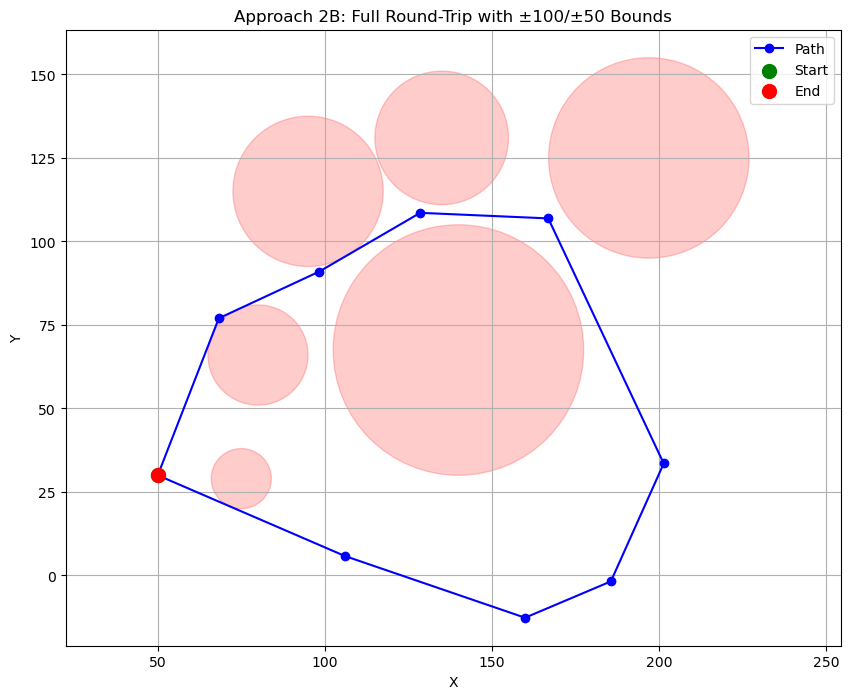

In [7]:
# One-Go Approach

bounds_one_go = [
    (68 - 100, 68 + 100),   (77 - 100, 77 + 100),     # w1
    (97 - 100, 97 + 100),   (91 - 100, 91 + 100),     # w2
    (125 - 100, 125 + 100), (105 - 100, 105 + 100),   # w3
    (167 - 0.1, 167 + 0.1), (107 - 0.1, 107 + 0.1),  # w4 (fixed midpoint)
    (109 - 100, 109 + 100), (67 - 100, 67 + 100),     # w5
    (108 - 100, 108 + 100), (66 - 100, 66 + 100),     # w6
    (107 - 100, 107 + 100), (65 - 100, 65 + 100),     # w7
    (106 - 100, 106 + 100), (64 - 100, 64 + 100)      # w8
]


result_one_go = direct(
    lambda coords: cost(coords, origin, origin, threats,
                        lmin=10, phi_max=np.radians(42.5),
                        mu=1, nu=10, rho=1),
    bounds=bounds_one_go,
    maxiter=256,
    maxfun=500000,
    vol_tol=0,
    locally_biased=False
)

print("One-Go Result:", result_one_go.message)
print_report(result_one_go, origin, origin, threats)
plot_path(result_one_go, origin, origin, threats, title="Approach 2B: Full Round-Trip with ±100/±50 Bounds")


# Visualize the DIRECT rectangles 
### For generating an image to put on the presentation slide, does not affect the code results

# Restart mode with 128 iterations

In [8]:
from scipy.optimize import OptimizeResult
import numpy as np
from typing import Callable, Iterable, Tuple

# Restart strategy function
def direct_with_restarts(
    func: Callable,
    bounds: Iterable[Tuple[float, float]],
    num_restarts: int = 3,
    shrink_factor: float = 0.5,
    min_bound_size: float = 1e-6,
    **kwargs
) -> OptimizeResult:
    """
    Runs the optimization algorithm with restarts shrinking bounds around the best solution.
    """
    lb = np.array([b[0] for b in bounds])
    ub = np.array([b[1] for b in bounds])
    best_result = None
    best_fun = np.inf
    func_calls = 0

    for restart in range(num_restarts + 1):  # Include initial run
        print(f"=== Restart {restart} ===")
        # Run optimization
        result = direct(func, bounds=list(zip(lb, ub)), **kwargs)
        
        # Update best result if current is better
        func_calls += result.nfev
        if result.fun < best_fun:
            best_fun = result.fun
            best_result = result
        
        # For restarts adjust bounds around the best solution
        if restart < num_restarts:
            current_x = np.array(result.x)
            bound_widths = (ub - lb) * shrink_factor
            bound_widths = np.maximum(bound_widths, min_bound_size)
            lb_new = np.maximum(lb, current_x - bound_widths / 2)
            ub_new = np.minimum(ub, current_x + bound_widths / 2)
            lb_new = np.minimum(lb_new, ub_new - min_bound_size)
            ub_new = np.maximum(ub_new, lb_new + min_bound_size)
            lb, ub = lb_new, ub_new

    print(f"Total function calls: {func_calls}")
    return best_result

=== Restart 0 ===
=== Restart 1 ===
Total function calls: 124206
One-Go Result with Restarts: Number of iterations is larger than maxiter=128
Path length: 394.80 km
Cost: 404.10
Maximum turn angle: 43.46 degrees
Total threat violation distance: 0.00 km
Number of function calls: 72371

Waypoints:
  (68.00, 77.00)
  (97.25, 91.00)
  (137.10, 110.43)
  (166.90, 106.89)
  (190.94, 79.26)
  (190.02, 30.97)
  (180.03, 19.39)
  (111.93, 3.20)



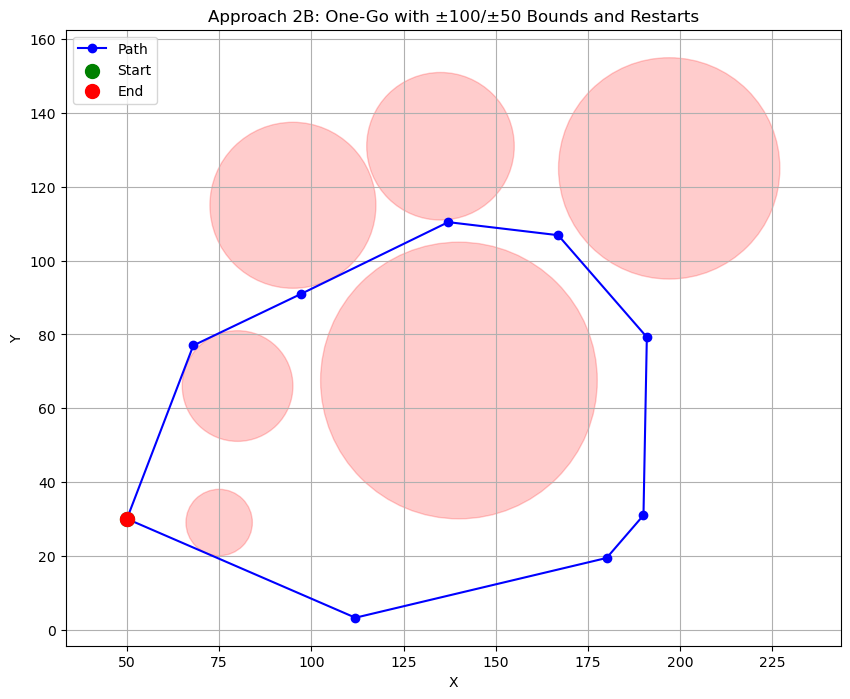

In [9]:
result_one_go_restarts = direct_with_restarts(
    lambda coords: cost(coords, origin, origin, threats,
                        lmin=10, phi_max=np.radians(42.5),
                        mu=1, nu=10, rho=1),
    bounds=bounds_one_go,
    num_restarts=1, # This variable controls how many times the search restarts. We tested values [1, 3, 5], which correspond to 2, 4, and 6 restarts.
    shrink_factor=0.9,
    min_bound_size=0.1,
    maxiter=128,
    maxfun=500000,
    vol_tol=0,
    locally_biased=False
)

print("One-Go Result with Restarts:", result_one_go_restarts.message)
print_report(result_one_go_restarts, origin, origin, threats)
plot_path(result_one_go_restarts, origin, origin, threats,
          title="Approach 2B: One-Go with ±100/±50 Bounds and Restarts")